# Data Scraping 

In [ ]:
import os
import time
import requests
from PIL import Image
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from mtcnn import MTCNN

# Function to download an image given a URL
def download_image(url, save_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)

# Function to check if the image contains a single face
def is_single_face(image_path):
    try:
        img = Image.open(image_path)
        img = img.convert("RGB")
        pixels = img.resize((224, 224))
        pixels = np.asarray(pixels)

        detector = MTCNN()
        faces = detector.detect_faces(pixels)

        return len(faces) == 1

    except Exception as e:
        print(f"Error in is_single_face: {str(e)}")
        return False

# Function to scrape images for a given query and count
def scrape_images(query, count):
    # Configure Selenium options
    options = Options()
    options.add_argument('--headless')  # Run Chrome in headless mode
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    # Set path to chromedriver executable
    chromedriver_path = '/chromedriver'  # Replace with the actual path to chromedriver executable

    # Create a new Chrome browser instance
    service = Service(chromedriver_path)
    driver = webdriver.Chrome(service=service, options=options)

    # Perform Google search
    search_url = f"https://www.google.com/search?q={query}&tbm=isch"
    driver.get(search_url)
    
    # Print the current URL
    print("Current URL:", driver.current_url)

    # Print the page title
    print("Page Title:", driver.title)
    # Scroll to the end of the page to load more images
    last_height = driver.execute_script("return document.body.scrollHeight")
    while count > 0:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)  # Wait for the page to load
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    # Parse the HTML content
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Find and download images
    image_count = 0
    for img in soup.find_all('img'):
        image_url = img.get('src') or img.get('data-src')
        if image_url and image_url.startswith('https://') and 'googleusercontent' not in image_url:
            # Download image
            
            image_count += 1
            image_filename = f"{query}_{image_count}.jpg"
            save_dir = os.path.join('celebrities', query.replace(" ", "_"))
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, image_filename)
            download_image(image_url, save_path)

            # Check if the image contains a single face
            if not is_single_face(save_path):
                if os.path.exists(save_path):
                    os.remove(save_path)  # Remove the image if it doesn't contain a single face
                continue

            count -= 1
            if count == 0:
                break
            
    # Close the browser
    driver.quit()

In [ ]:
# Create directory to save images
os.makedirs('celebrities_data', exist_ok=True)

# Define the list of celebrities and the number of images to download for each
celebrities = [
#     {"name": "Brad Pitt", "count": 200},
#     {"name": "Angelina Jolie", "count": 200},
#     {"name": "Leonardo DiCaprio", "count": 200},
#     {"name": "Jennifer Aniston", "count": 200},
#     {"name": "Tom Cruise", "count": 200},
#     {"name": "Julia Roberts", "count": 200},
#     {"name": "Will Smith", "count": 200},
#     {"name": "Scarlett Johansson", "count": 200},       
#     {"name": "Robert Downey Jr.", "count": 200},          
#     {"name": "Charlize Theron", "count": 200},
#     {"name": "Johnny Depp", "count": 200},
#     {"name": "Meryl Streep", "count": 200},
#     {"name": "George Clooney", "count": 200}, 
#     {"name": "Nicole Kidman", "count": 200},
#     {"name": "Dwayne Johnson", "count": 200},
#     {"name": "Natalie Portman", "count": 200},
#     {"name": "Chris Hemsworth", "count": 200},
#     {"name": "Emma Stone", "count": 200},
#     {"name": "Ryan Reynolds", "count": 200},
    {"name": "Jennifer Lawrence", "count": 200},
    
    # Add more celebrities and their desired image count
]

# Download images for each celebrity
for celebrity in celebrities:
    scrape_images(celebrity["name"], celebrity["count"])

# 1) Preprocessing (Face Detection Model) 

In [135]:
# # MTCNN 

# import os
# import cv2
# from mtcnn import MTCNN

# # Load the MTCNN model for face detection
# detector = MTCNN()

# # Function to preprocess and detect faces in an image
# def preprocess_and_detect_faces(image):
#     # Convert the image to RGB
#     rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Perform face detection using MTCNN
#     detections = detector.detect_faces(rgb_image)

#     # Iterate over the detected faces
#     for detection in detections:
#         x, y, w, h = detection['box']
        
#         # Crop the face region from the original image
#         face = image[y:y+h, x:x+w]

#         # Resize the face to a fixed size (e.g., 224x224) for further processing
#         resized_face = cv2.resize(face, (224, 224))

#         # Perform any additional preprocessing steps if needed (e.g., normalization)

#         # Return the preprocessed face
#         return resized_face

#     # If no faces are detected, return None
#     return None

# # Function to process images in a folder
# def process_images_in_folder(folder_path, output_folder_path):
#     # Create the output folder if it doesn't exist
#     os.makedirs(output_folder_path, exist_ok=True)

#     # Iterate over the images in the folder
#     for filename in os.listdir(folder_path):
#         if filename.endswith(".jpg") or filename.endswith(".png"):
#             # Load the image
#             image_path = os.path.join(folder_path, filename)
#             image = cv2.imread(image_path)

#             # Preprocess and detect faces in the image
#             preprocessed_face = preprocess_and_detect_faces(image)

#             if preprocessed_face is not None:
#                 # Save the preprocessed face in the output folder
#                 output_path = os.path.join(output_folder_path, filename)
#                 cv2.imwrite(output_path, preprocessed_face)

# # Function to process images in multiple folders
# def process_images_in_folders(parent_folder_path):
#     # Iterate over the subfolders in the parent folder
#     for folder_name in os.listdir(parent_folder_path):
#         folder_path = os.path.join(parent_folder_path, folder_name)
#         if os.path.isdir(folder_path):
#             # Create the corresponding output folder for the current subfolder
#             output_folder_path = os.path.join(parent_folder_path + "_preprocessed4", folder_name)
#             process_images_in_folder(folder_path, output_folder_path)

# # Example usage
# parent_folder_path = "data/"
# process_images_in_folders(parent_folder_path)


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 1s 603ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step


In [114]:
# import os
# import cv2

# # Load the face detection cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# # Function to preprocess and detect faces in an image
# def preprocess_and_detect_faces(image):
#     # Convert the image to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Detect faces in the grayscale image
#     faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

#     # Iterate over the detected faces
#     for (x, y, w, h) in faces:
#         # Crop the face region from the original image
#         face = image[y:y+h, x:x+w]

#         # Resize the face to a fixed size (e.g., 224x224) for ResNet-34
#         resized_face = cv2.resize(face, (224, 224))

#         # Perform any additional preprocessing steps if needed (e.g., normalization)

#         # Return the preprocessed face
#         return resized_face

# # Function to process images in a folder
# def process_images_in_folder(folder_path, output_folder_path):
#     # Create the output folder if it doesn't exist
#     os.makedirs(output_folder_path, exist_ok=True)

#     # Iterate over the images in the folder
#     for filename in os.listdir(folder_path):
#         if filename.endswith(".jpg") or filename.endswith(".png"):
#             # Load the image
#             image_path = os.path.join(folder_path, filename)
#             image = cv2.imread(image_path)

#             # Preprocess and detect faces in the image
#             preprocessed_face = preprocess_and_detect_faces(image)

#             if preprocessed_face is not None:
#                 # Save the preprocessed face in the output folder
#                 output_path = os.path.join(output_folder_path, filename)
#                 cv2.imwrite(output_path, preprocessed_face)

# # Process images in multiple folders
# def process_images_in_folders(parent_folder_path):
#     # Iterate over the subfolders in the parent folder
#     for folder_name in os.listdir(parent_folder_path):
#         folder_path = os.path.join(parent_folder_path, folder_name)
#         if os.path.isdir(folder_path):
#             # Create the corresponding output folder for the current subfolder
#             output_folder_path = os.path.join(parent_folder_path + "_preprocessed", folder_name)
#             process_images_in_folder(folder_path, output_folder_path)

# # Example usage
# parent_folder_path = "data/"
# process_images_in_folders(parent_folder_path)


In [323]:
# #DNN model 
# import os
# import cv2
# import numpy as np

# # Load the pre-trained face detection model
# net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")

# # Function to preprocess and detect faces in an image
# def preprocess_and_detect_faces(image):
#     # Construct an input blob for the network
#     blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0), False, False)

#     # Set the input blob for the network
#     net.setInput(blob)

#     # Run forward pass to perform face detection
#     detections = net.forward()

#     # Iterate over the detected faces
#     for i in range(detections.shape[2]):
#         confidence = detections[0, 0, i, 2]

#         # Filter out weak detections with a confidence threshold
#         if confidence > 0.5:
#             # Get the bounding box coordinates of the face
#             box = detections[0, 0, i, 3:7] * np.array([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])
#             (x, y, w, h) = box.astype("int")

#             # Crop the face region from the original image
#             face = image[y:y + h, x:x + w]

#             # Perform any additional preprocessing steps if needed

#             # Return the preprocessed face
#             return face

#     # If no faces are detected, return None
#     return None

# # Function to process images in a folder
# def process_images_in_folder(folder_path, output_folder_path):
#     # Create the output folder if it doesn't exist
#     os.makedirs(output_folder_path, exist_ok=True)

#     # Iterate over the images in the folder
#     for filename in os.listdir(folder_path):
#         if filename.endswith(".jpg") or filename.endswith(".png"):
#             # Load the image
#             image_path = os.path.join(folder_path, filename)
#             image = cv2.imread(image_path)

#             # Preprocess and detect faces in the image
#             preprocessed_face = preprocess_and_detect_faces(image)

#             if preprocessed_face is not None:
#                 # Save the preprocessed face in the output folder
#                 output_path = os.path.join(output_folder_path, filename)
#                 cv2.imwrite(output_path, preprocessed_face)

# # Function to process images in multiple folders
# def process_images_in_folders(parent_folder_path):
#     # Iterate over the subfolders in the parent folder
#     for folder_name in os.listdir(parent_folder_path):
#         folder_path = os.path.join(parent_folder_path, folder_name)
#         if os.path.isdir(folder_path):
#             # Create the corresponding output folder for the current subfolder
#             output_folder_path = os.path.join(parent_folder_path + "_preprocessed2", folder_name)
#             process_images_in_folder(folder_path, output_folder_path)

# # Example usage
# parent_folder_path = "data/"
# process_images_in_folders(parent_folder_path)


In [325]:
#REsnet
import os
import cv2
import numpy as np

# Load the pre-trained face detection model
model_path = "opencv_face_detector.pbtxt"  # Update with the path to your face detection model
model_config = "deploy.prototxt"  # Update with the path to your model configuration file
model_weights = "res10_300x300_ssd_iter_140000.caffemodel"  # Update with the path to your model weights file
net = cv2.dnn.readNetFromCaffe(model_config, model_weights)

# Function to preprocess and detect faces in an image
def preprocess_and_detect_faces(image):
    # Construct an input blob for the network
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0), False, False)

    # Set the input blob for the network
    net.setInput(blob)

    # Run forward pass to perform face detection
    detections = net.forward()

    # Iterate over the detected faces
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        # Filter out weak detections with a confidence threshold
        if confidence > 0.5:
            # Get the bounding box coordinates of the face
            box = detections[0, 0, i, 3:7] * np.array([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])
            (x, y, w, h) = box.astype("int")

            # Crop the face region from the original image
            face = image[y:y + h, x:x + w]

            # Perform any additional preprocessing steps if needed

            # Return the preprocessed face
            return face

    # If no faces are detected, return None
    return None

# Function to process images in a folder
def process_images_in_folder(folder_path, output_folder_path):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder_path, exist_ok=True)

    # Iterate over the images in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Load the image
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)

            # Preprocess and detect faces in the image
            preprocessed_face = preprocess_and_detect_faces(image)

            if preprocessed_face is not None:
                # Save the preprocessed face in the output folder
                output_path = os.path.join(output_folder_path, filename)
                cv2.imwrite(output_path, preprocessed_face)

# Function to process images in multiple folders
def process_images_in_folders(parent_folder_path):
    # Iterate over the subfolders in the parent folder
    for folder_name in os.listdir(parent_folder_path):
        folder_path = os.path.join(parent_folder_path, folder_name)
        if os.path.isdir(folder_path):
            # Create the corresponding output folder for the current subfolder
            output_folder_path = os.path.join(parent_folder_path + "_preprocessed3", folder_name)
            process_images_in_folder(folder_path, output_folder_path)

# Example usage
parent_folder_path = "data/"
process_images_in_folders(parent_folder_path)


In [6]:
!ls

Customer Segmentation.ipynb      celebrities copy
Customer_Segmentation_pkl.ipynb  celebrities_data
Demo_                            chromedriver
EDA and Data Preprocessing.ipynb data 2
Future Forecasting.ipynb         django-data.csv
Recommendation_System.ipynb      nishad_notebook.ipynb
Untitled.ipynb                   resnet_model.h5
celebrities                      rfm_pipeline.pkl


In [327]:
path = 'data/_preprocessed3'
folders = os.listdir(path)
folders

['1825030',
 '1825029M',
 '1825005M',
 '1825036M',
 '1825003',
 '1825027F',
 '1825007M',
 '1825013F']

In [281]:
folders.remove('.DS_Store')
folders

ValueError: list.remove(x): x not in list

# 2.  Train Test Splitting


In [329]:
# Train Test Splitting Code  
import os
import random
import shutil

# Set the paths to the main directory and the person directories
main_dir = 'data/_preprocessed3'
person_dirs = folders

# Set the train-test split ratio (e.g., 0.8 for 80% train, 20% test)
split_ratio = 0.8

# Create train and test directories
train_dir = os.path.join(main_dir, 'Training')
test_dir = os.path.join(main_dir, 'Testing')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each person's directory and split the images
for person_dir in person_dirs:
    person_images = os.listdir(os.path.join(main_dir, person_dir))
    random.shuffle(person_images)

    split_index = int(len(person_images) * split_ratio)
    train_images = person_images[:split_index]
    test_images = person_images[split_index:]

    # Move train images to the train directory
    person_train_dir = os.path.join(train_dir, person_dir)
    os.makedirs(person_train_dir, exist_ok=True)
    for train_image in train_images:
        src_path = os.path.join(main_dir, person_dir, train_image)
        dst_path = os.path.join(person_train_dir, train_image)
        shutil.move(src_path, dst_path)

    # Move test images to the test directory
    person_test_dir = os.path.join(test_dir, person_dir)
    os.makedirs(person_test_dir, exist_ok=True)
    for test_image in test_images:
        src_path = os.path.join(main_dir, person_dir, test_image)
        dst_path = os.path.join(person_test_dir, test_image)
        shutil.move(src_path, dst_path)

print('Dataset split complete!')


Dataset split complete!


In [330]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.resnet import ResNet50
from tensorflow.keras.applications import ResNet152, ResNet152V2
from keras.applications import ResNet101V2, VGG16
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import numpy as np
from glob import glob

IMAGE_SIZE = [224, 224]
train_path = "data/_preprocessed3/Training"
test_path = "data/_preprocessed3/Testing"



In [331]:
resnet = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet',include_top = False)


In [332]:
for layer in resnet.layers:
  layer.trainable = False 


In [351]:
# # Create a new model
# model = Sequential()
# model.add(resnet)
# model.add(Dropout(0.5))
# model.add(Flatten())

# model.add(Dense(15, activation='softmax'))
# model.summary()

In [333]:
### Layers of the model 

x = Flatten()(resnet.output)
#x = Dropout(0.25)(x)
# Dense layer
prediction = Dense(8, activation = 'softmax')(x)

model = Model(inputs=resnet.input, outputs = prediction)

model.summary()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_17[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
          

 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
          

                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
          

                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalizat

In [334]:
# # tell the model what cost and optimization method to use
# import keras 
# def resnet50tl(input_shape, outclass, sigma='sigmoid'):
    
#     base_model = None
#     base_model = keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    
#     top_model = Sequential()
#     top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
#     for i in range(2):
#         top_model.add(Dense(4096, activation='relu'))
#         top_model.add(Dropout(0.5))
#     top_model.add(Dense(outclass, activation=sigma))

#     model = None
#     model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
#     return model

#model = resnet50tl((224, 224, 3), 8, 'softmax')
lr = 1e-5
decay = 1e-7 #0.0
optimizer = RMSprop(lr=lr, decay=decay)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])



# optimizer = Adam(learning_rate=0.001)
# model.compile(
#     loss='categorical_crossentropy',
#     optimizer=optimizer,
#     metrics=['accuracy']
# )


In [335]:
from keras.preprocessing.image import ImageDataGenerator


In [336]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
#     shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    )

In [195]:
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)


In [337]:
test_datagen = ImageDataGenerator(rescale = 1./255)


In [338]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


Found 345 images belonging to 8 classes.


In [339]:
testing_set = test_datagen.flow_from_directory(test_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


Found 89 images belonging to 8 classes.


In [340]:
r = model.fit(
    training_set,
    validation_data = testing_set,
    epochs = 50, 
    steps_per_epoch = len(training_set), 
    validation_steps = len(testing_set)
)

Epoch 1/50
11/11 [==============================] - 25s 2s/step - loss: 2.9073 - accuracy: 0.1565 - val_loss: 2.3064 - val_accuracy: 0.2360
Epoch 2/50
11/11 [==============================] - 22s 2s/step - loss: 2.0765 - accuracy: 0.3217 - val_loss: 1.7873 - val_accuracy: 0.3820
Epoch 3/50
11/11 [==============================] - 22s 2s/step - loss: 1.5586 - accuracy: 0.4783 - val_loss: 1.4666 - val_accuracy: 0.4719
Epoch 4/50
11/11 [==============================] - 23s 2s/step - loss: 1.3112 - accuracy: 0.5681 - val_loss: 1.2530 - val_accuracy: 0.5955
Epoch 5/50
11/11 [==============================] - 22s 2s/step - loss: 1.1424 - accuracy: 0.6000 - val_loss: 1.0877 - val_accuracy: 0.6966
Epoch 6/50
11/11 [==============================] - 22s 2s/step - loss: 0.9365 - accuracy: 0.6638 - val_loss: 0.9586 - val_accuracy: 0.7303
Epoch 7/50
11/11 [==============================] - 22s 2s/step - loss: 0.9021 - accuracy: 0.6783 - val_loss: 0.8703 - val_accuracy: 0.7528
Epoch 8/50
11/11 [==

In [341]:
# Evaluate the model
scores = model.evaluate(testing_set)
print("Validation Loss: {:.2f}".format(scores[0]))
print("Validation Accuracy: {:.2f}%".format(scores[1] * 100))
 


3/3 [==============================] - 5s 1s/step - loss: 0.3761 - accuracy: 0.8652
Validation Loss: 0.38
Validation Accuracy: 86.52%


1/1 [==============================] - 0s 86ms/step
Person: 1825029M


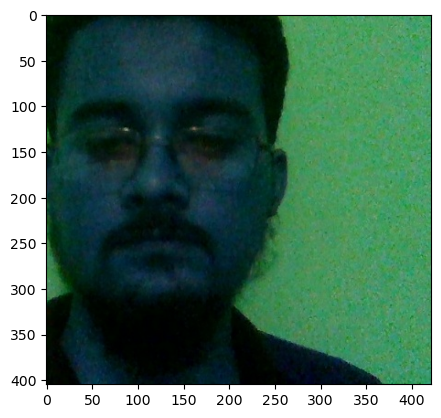

In [349]:
import matplotlib.pyplot as plt
import cv2 as cv
image_path = 'data/_preprocessed3/Testing/1825029M/photo_2.jpg'
img = cv.imread(image_path)
#img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(img)

# Preprocess the image
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (224, 224))  # Resize to the desired input shape
img = img / 255.0  # Normalize pixel values between 0 and 1

# Expand dimensions
img = np.expand_dims(img, axis=0)

# Make prediction using the model
predictions = model.predict(img)
predicted_labels = np.argmax(predictions, axis=1)

# Make predictions
#predictions = model.predict(image)
#predicted_labels = [class_names[np.argmax(pred)] for pred in predictions]
labels = {0: 'ASH1825003', 1:'1825005M', 2:'1825007M', 3:'1825013F', 4:'1825027F', 5:'1825029M', 6:'1825030', 7:'1825036M'}
print("Person:", labels[int(predicted_labels)])

1/1 [==============================] - 0s 84ms/step
Person: 1825036M


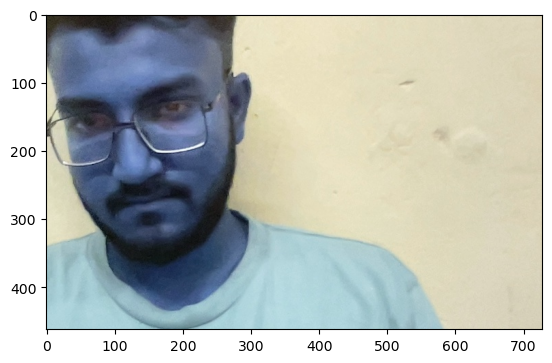

In [350]:
import matplotlib.pyplot as plt
import cv2 as cv
image_path = 'data/_preprocessed3/Testing/1825036M/photo_18.jpg'
img = cv.imread(image_path)
#img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(img)

# Preprocess the image
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (224, 224))  # Resize to the desired input shape
img = img / 255.0  # Normalize pixel values between 0 and 1

# Expand dimensions
img = np.expand_dims(img, axis=0)

# Make prediction using the model
predictions = model.predict(img)
predicted_labels = np.argmax(predictions, axis=1)

# Make predictions
#predictions = model.predict(image)
#predicted_labels = [class_names[np.argmax(pred)] for pred in predictions]
labels = {0: 'ASH1825003', 1:'1825005M', 2:'1825007M', 3:'1825013F', 4:'1825027F', 5:'1825029M', 6:'1825030', 7:'1825036M'}
print("Person:", labels[int(predicted_labels)])

In [352]:
import joblib

# Define the path where you want to save the model
model_path = 'face_recognizer_model.pkl'

# Save the model using joblib
joblib.dump(model, model_path)


INFO:tensorflow:Assets written to: ram://52e3a80a-0904-42d6-a364-daa51360fdf5/assets


INFO:tensorflow:Assets written to: ram://52e3a80a-0904-42d6-a364-daa51360fdf5/assets


['face_recognizer_model.pkl']

In [355]:
m  = joblib.load('face_recognizer_model.pkl')

In [364]:
import cv2
import numpy as np

# Load the pre-trained face detection model
model_path = "opencv_face_detector.pbtxt"  # Update with the path to your face detection model
model_config = "deploy.prototxt"  # Update with the path to your model configuration file
model_weights = "res10_300x300_ssd_iter_140000.caffemodel"  # Update with the path to your model weights file
net = cv2.dnn.readNetFromCaffe(model_config, model_weights)

# def process_single_image(image_path, output_path):
#     # Load the image
#     image = cv2.imread(image_path)

#     # Preprocess and detect faces in the image
#     preprocessed_face = preprocess_and_detect_faces(image)

#     if preprocessed_face is not None:
#         # Save the preprocessed face
#         cv2.imwrite(output_path, preprocessed_face)
#         print("Preprocessed face saved successfully!")
#     else:
#         print("No face detected in the image.")

def preprocess_and_detect_faces(image):
    # Construct an input blob for the network
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0), False, False)

    # Set the input blob for the network
    net.setInput(blob)

    # Run forward pass to perform face detection
    detections = net.forward()

    # Iterate over the detected faces
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        # Filter out weak detections with a confidence threshold
        if confidence > 0.5:
            # Get the bounding box coordinates of the face
            box = detections[0, 0, i, 3:7] * np.array([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])
            (x, y, w, h) = box.astype("int")

            # Crop the face region from the original image
            face = image[y:y + h, x:x + w]

            # Perform any additional preprocessing steps if needed
            face = cv2.resize(face, (224, 224))
            face = face / 255.0
            face = np.expand_dims(face, axis=0)
            # Return the preprocessed face
            return face
    # If no faces are detected, return None
    return None

# Example usage
image_path = "img.jpg"  # Update with the path to your image file
#output_path = "preprocessed_face.jpg"  # Update with the desired output path
processed_image = preprocess_and_detect_faces(cv2.imread(image_path))


In [366]:
# Make prediction using the model
predictions = m.predict(processed_image)
predicted_labels = np.argmax(predictions, axis=1)

# Make predictions
#predictions = model.predict(image)
#predicted_labels = [class_names[np.argmax(pred)] for pred in predictions]
labels = {0: 'ASH1825003', 1:'1825005M', 2:'1825007M', 3:'1825013F', 4:'1825027F', 5:'1825029M', 6:'1825030', 7:'1825036M'}
print("Person:", labels[int(predicted_labels)])

1/1 [==============================] - 1s 676ms/step
Person: 1825036M
